## Introduction

The purpose of this project is to demonstrate how data can be used to segment customers based on their interactions with the company, and their demographics. The dataset used here contains data collected from a marketing campaign, and as this is a segmentation task, and we have no known target variable, I will use unsupervised clustering methods to attempt to segment the customers into groups with similar behaviours and/or demographics. 

## Imports and Data Access

In [102]:
%pip install --upgrade kmodes

Note: you may need to restart the kernel to use updated packages.


In [103]:
%pip install dython

Note: you may need to restart the kernel to use updated packages.


In [104]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dython
from datetime import datetime as dt
from sklearn.preprocessing import quantile_transform, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.cm as cm
from kmodes.kprototypes import KPrototypes

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

In [105]:
# Read in the data
df = pd.read_csv("marketing_campaign.csv", "\t")

## Exploratory Analysis

In [106]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [107]:
df.shape

(2240, 29)

In [108]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

There are a small number of nulls in the income column (24). I have no way of knowing whether these are customers who have no income or whether the data is missing. For this reason, I will decide not to lose any data, and I will replace the nulls with zeros as this is a valid scenario. 

In [109]:
# Check for any NaNs and replace with zeros
df.Income = df.Income.fillna(0)

In [110]:
desc = df.describe()
desc = desc.transpose()
desc

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2240.0,51687.459375,25609.342730,0.0,34722.00,51075.0,68289.75,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


In [111]:
# import dataframe_image as dfi
 
# dfi.export(desc, 'data_description.png')

### Explore binary feature distributions

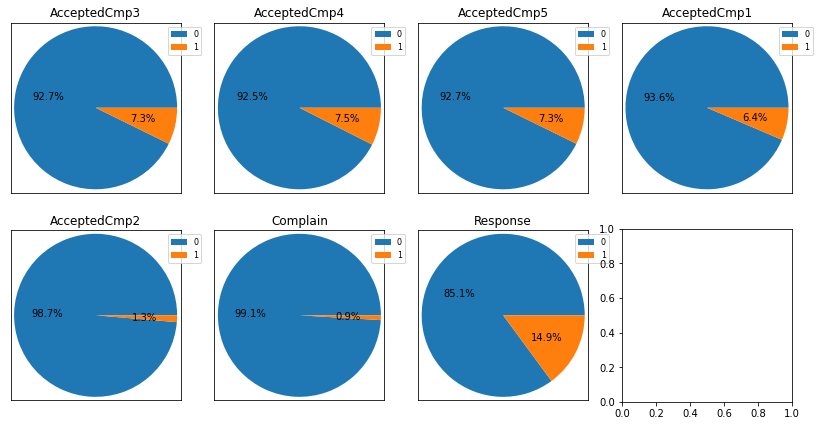

In [112]:
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
b_feature_count = len(b_feature_names)

# determine required rows and columns
b_column_count = 4
b_row_count = math.ceil(b_feature_count / b_column_count)

 
# configure figure layout
fig, ax = plt.subplots(b_row_count, b_column_count, figsize =(b_column_count * 3.5, b_row_count * 3.5))

 
# render distribution of each feature
for k in range(0,b_feature_count):
  
  # determine row & col position
    b_col = k % b_column_count
    b_row = int(k / b_column_count)
    
  # determine feature to be plotted
    f = b_feature_names[k]
    value_counts = df[f].value_counts()

  # render pie chart
    ax[b_row][b_col].pie(
    x = value_counts.values,
    labels = value_counts.index,
    explode = None,
    autopct='%1.1f%%',
    labeldistance=None,
    #pctdistance=0.4,
    frame=True,
    radius=0.48,
    center=(0.5, 0.5)
    )

  # clear frame of ticks
    ax[b_row][b_col].set_xticks([])
    ax[b_row][b_col].set_yticks([])

  # legend & feature name
    ax[b_row][b_col].legend(bbox_to_anchor=(0.9,1),loc='upper left', fontsize=8)
    ax[b_row][b_col].set_title(f"{b_feature_names[k]}")

### Explore continuous feature distributions

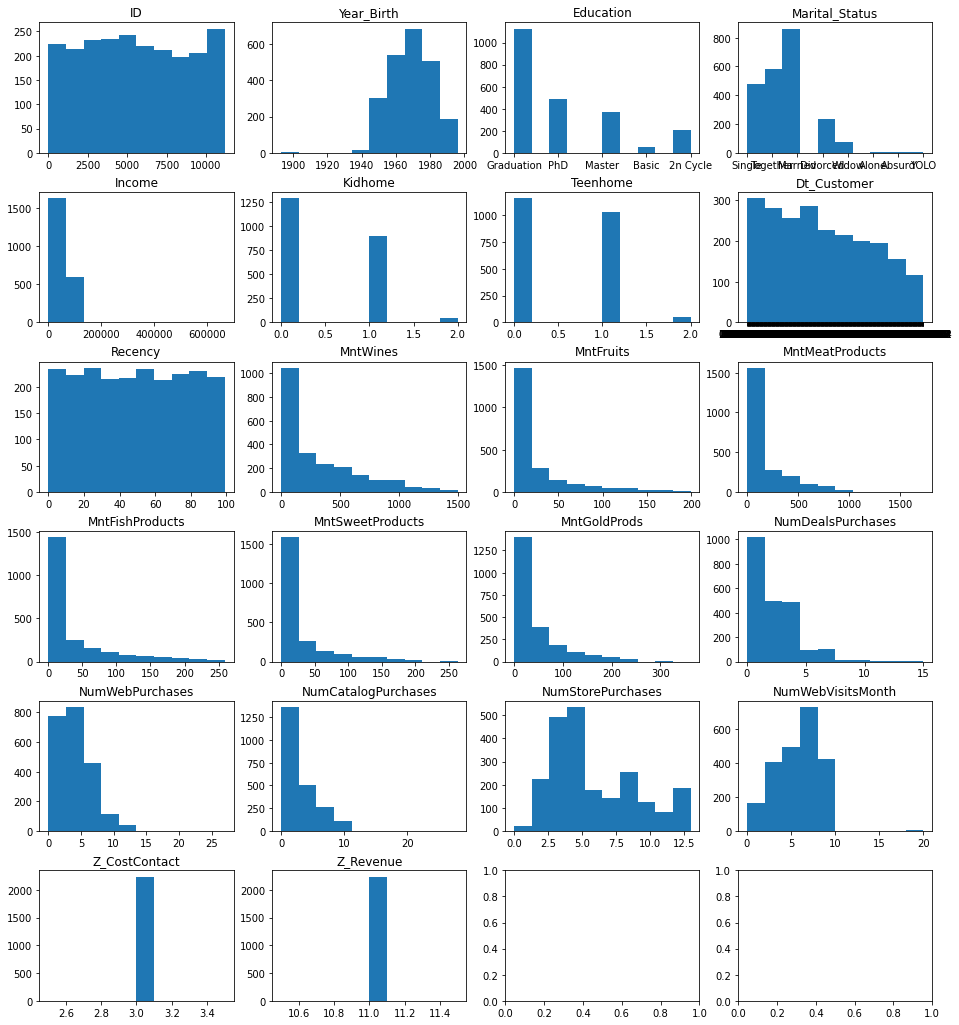

In [113]:
c_feature_names = [col for col in df.columns if col not in b_feature_names]
feature_count = len(c_feature_names)
 
# determine required rows and columns for visualizations
column_count = 4
row_count = math.ceil(feature_count / column_count)

# configure figure layout
fig, ax = plt.subplots(row_count, column_count, figsize =(column_count * 4, row_count * 3))

# render distribution of each feature
for k in range(0,feature_count):
  # determine row & col position
    col = k % column_count
    row = int(k / column_count)

  # set figure at row & col position
    ax[row][col].hist(df[c_feature_names[k]], rwidth=1, bins=10) # histogram
    #ax[row][col].set_xlim(0,1)   # set x scale
    #ax[row][col].set_ylim(0,df.shape[0]) # set y scale 
    ax[row][col].set_title(f"{c_feature_names[k]}")   # feature name in chart
    plt.subplots_adjust(hspace=0.3)

It appeats as though we have features here that can be split in to four broad categories. 
- Person - this is mainly demographic information about the customer
- Product - this is data on the amount a customer spent on specific product groups
- Promotion - this is data on how the customer interacts with promotional activity / marketing campaigns
- Place - this is data on where / how the customer makes their purchases 

We can also see above that there are two featurs, Z_CostContact and Z_Revenue which appear just to be constant. We will drop these from our features, and we will now try to extract further value from the remaining features. So, for example, I will create an age feature from the Year of Birth data we havea and I will combine all product spend into a Total_Spend feature, among other things. 

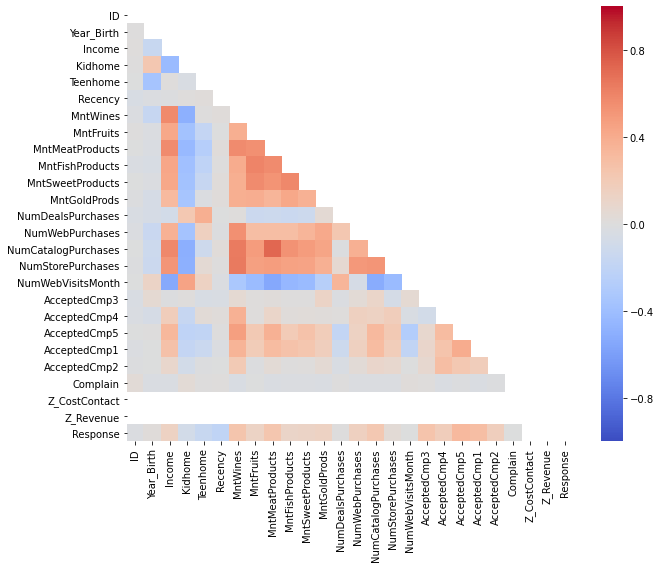

In [114]:
# Get correlation matrix
original_features_corr = df.corr() 

# use a mask to remove top-half of heatmap
top_mask = np.zeros(original_features_corr.shape, dtype=bool)
top_mask[np.triu_indices(len(top_mask))] = True

plt.figure(figsize=(10,8))

# Plot heatmap
hmap = sns.heatmap(
  original_features_corr,
  cmap = 'coolwarm',
  vmin =  1.0, 
  vmax = -1.0,
  mask = top_mask
  )

In [115]:
# Drop Z_CostContact and Z_Revenue as they appear to just be constants
df = df.drop(["Z_CostContact", "Z_Revenue"], axis=1)

## Feature Engineering

In [116]:
# Define the year today
today_year = dt.today().year
today_date = dt.today()

# Create age feature
df['age'] = today_year - df['Year_Birth']

# Create has_child feature
df['has_child'] = np.where(df['Kidhome'] > 0, 1, 0)

# Create a total_spend feature
df['total_spend'] = df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']

# Create a total_number_purchases feature
df['total_purchases'] = df['NumWebPurchases']+ df['NumCatalogPurchases']+ df['NumStorePurchases']

# Replace number of purchases with fraction of purchases by location and fraction of purchase w/deals
# df['purchases_with_deals'] = df["NumDealsPurchases"]/df['total_purchases']
# df['web_purchase_fraction'] = df["NumWebPurchases"]/df['total_purchases']
# df['catalog_purchase_fraction'] = df["NumCatalogPurchases"]/df['total_purchases']
# df['store_purchase_fraction'] = df["NumStorePurchases"]/df['total_purchases']

# Combine the Accepted Promos into a Count
df["promos_accepted"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]

# Is it worth grouping marital statuses together? 
df["Marital_Status"] = df["Marital_Status"].replace({'Divorced':'Single', 'Single':'Single', 'Alone':'Single', 'Widow':'Single', 'Absurd':'Single', 'YOLO':'Single','Married':'Married','Together':'Married'})

# Deal with the date of customer's enrolment (create tenure)
today_date = dt.today()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['tenure'] = (today_date - df['Dt_Customer']).dt.days

# Improve education groupings
df['Education']=df['Education'].replace({'Basic':'Basic','2n Cycle':'Postgrad','Graduation':'Bachelor','Master':'Postgrad','PhD':'Postgrad'})


In [117]:
# Check for any NaNs arising from division and replace with zeros
df = df.fillna(0)

In [118]:
# Check for any data quality issues / zero division errors caused above
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,promos_accepted,tenure


In [119]:
## Some data quality issues arise with some of the feature creation above
# NumDealsPurchases = 15 but total_purchases = 0, giving np.inf datatype which cannot be used
# As I believe this to be a data quality issue I will drop these instances
df.drop([1232, 1829], axis=0, inplace=True)
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,promos_accepted,tenure


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2238 non-null   int64         
 1   Year_Birth           2238 non-null   int64         
 2   Education            2238 non-null   object        
 3   Marital_Status       2238 non-null   object        
 4   Income               2238 non-null   float64       
 5   Kidhome              2238 non-null   int64         
 6   Teenhome             2238 non-null   int64         
 7   Dt_Customer          2238 non-null   datetime64[ns]
 8   Recency              2238 non-null   int64         
 9   MntWines             2238 non-null   int64         
 10  MntFruits            2238 non-null   int64         
 11  MntMeatProducts      2238 non-null   int64         
 12  MntFishProducts      2238 non-null   int64         
 13  MntSweetProducts     2238 non-nul

In [121]:
# Select just relevant colums
df_ID = df['ID']
df = df.drop(["ID", "Year_Birth", "Kidhome", "Teenhome", "Dt_Customer", "MntWines", "MntFruits",
              "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "AcceptedCmp1", "AcceptedCmp2",
              "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1)

#"NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",

### Encoding

In [122]:
le = LabelEncoder()
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
for i in cat_cols:
    df[i] = le.fit_transform(df[[i]])

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [123]:
cat_cols

['Education', 'Marital_Status']

In [124]:
# Re-Run Identification of Binary / Continious Features and Add Categorical to Binary Features
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
cat_feature_names = b_feature_names + ["Education", "Marital_Status"]
c_feature_names = [col for col in df.columns if col not in cat_feature_names]

### Scale Continuous Features

In [125]:
# access continous features
cont_features = df[c_feature_names]

# apply quantile transform
qc_features = pd.DataFrame(
  quantile_transform(cont_features, output_distribution='normal', ignore_implicit_zeros=True),
  columns=cont_features.columns,
  copy=True)

# show transformed data
#qc_features

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_data.py:2503: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,age,total_spend,total_purchases,promos_accepted,tenure
0,0.251036,0.240671,0.648724,1.298271,2.033104,-0.253606,0.576075,0.848075,1.404533,1.189522,0.880888,1.994971
1,-0.170185,-0.279606,0.163824,-1.278137,-0.325577,-1.562721,-0.216204,1.118711,-1.471555,-1.233962,-5.199338,-1.738731
2,0.839048,-0.618059,-0.715218,1.298271,0.111890,1.044409,-0.514923,0.337506,0.374690,0.873515,-5.199338,-0.148584
3,-1.100268,-0.618059,0.163824,-0.633317,-5.199338,-0.253606,0.134645,-1.242061,-0.888309,-0.592444,-5.199338,-1.918441
4,0.255429,1.629992,1.362078,0.440383,0.378977,0.270485,-0.216204,-0.981540,0.043068,0.156199,-5.199338,-0.728240
5,0.410059,-0.953493,0.163824,0.723343,0.611996,1.044409,0.134645,0.211070,0.318693,0.873515,-5.199338,-0.212353
6,0.160942,-0.377630,1.037937,1.018778,0.378977,0.462610,0.134645,-0.086674,0.216269,0.482248,-5.199338,0.969427
7,-0.748135,-0.425228,0.163824,0.148584,-5.199338,-0.253606,1.184447,-1.331018,-0.304084,-0.287442,-5.199338,-0.089192
8,-0.911229,-0.849874,-0.715218,-0.198258,-5.199338,-1.562721,1.985876,-0.353487,-1.004131,-0.864365,0.880888,0.120906
9,-2.205423,0.489307,-0.715218,-1.278137,-5.199338,-5.199338,5.199338,1.593219,-0.935852,-2.696511,0.880888,-0.925332


In [126]:
qc_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2238 non-null   float64
 1   Recency              2238 non-null   float64
 2   NumDealsPurchases    2238 non-null   float64
 3   NumWebPurchases      2238 non-null   float64
 4   NumCatalogPurchases  2238 non-null   float64
 5   NumStorePurchases    2238 non-null   float64
 6   NumWebVisitsMonth    2238 non-null   float64
 7   age                  2238 non-null   float64
 8   total_spend          2238 non-null   float64
 9   total_purchases      2238 non-null   float64
 10  promos_accepted      2238 non-null   float64
 11  tenure               2238 non-null   float64
dtypes: float64(12)
memory usage: 209.9 KB


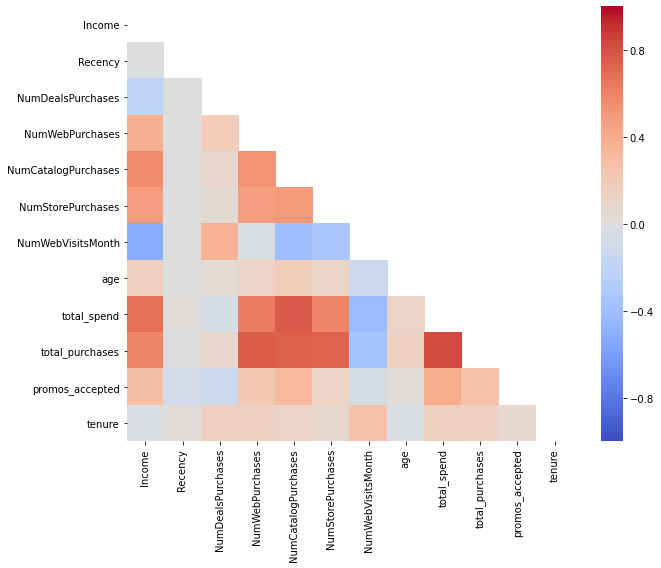

In [127]:
# Get correlation matrix
qc_features_corr = qc_features.corr() 

# use a mask to remove top-half of heatmap
top_mask = np.zeros(qc_features_corr.shape, dtype=bool)
top_mask[np.triu_indices(len(top_mask))] = True

plt.figure(figsize=(10,8))

# Plot heatmap
hmap = sns.heatmap(
  qc_features_corr,
  cmap = 'coolwarm',
  vmin =  1.0, 
  vmax = -1.0,
  mask = top_mask
  )

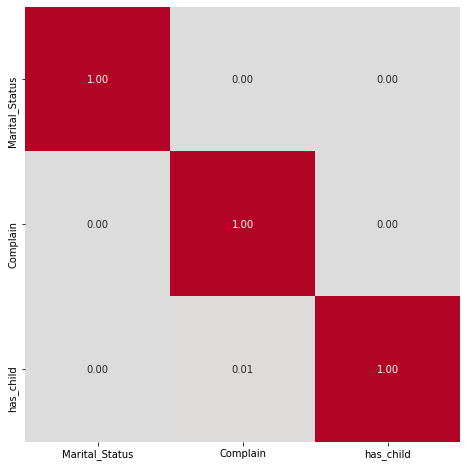

In [128]:
# Look at correlations between binary variables with Theil's U

_ = dython.nominal.associations(
  df[b_feature_names], 
  nominal_columns='all',
  nom_nom_assoc='theil',
  figsize=(10,8),
  cmap='coolwarm',
  vmax=1.0,
  vmin=0.0,
  cbar=False
  )

## Apply Dimensionality Reduction

In [129]:
variance_ratio = {}

for i in range(1, len(qc_features.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(qc_features)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
    
variance_ratio

{'n_1': 0.4472588220543258,
 'n_2': 0.6717340760173233,
 'n_3': 0.7452988275480031,
 'n_4': 0.8033776579587775,
 'n_5': 0.8541442784267013,
 'n_6': 0.8917129352645521,
 'n_7': 0.9245443361906938,
 'n_8': 0.9543556101742705,
 'n_9': 0.9753326690599633,
 'n_10': 0.9889319769446033,
 'n_11': 0.9961301757988494,
 'n_12': 1.0}

In [130]:
pca = PCA(n_components =4, random_state = 42)

pca.fit(qc_features)
data_pca = pd.DataFrame(pca.transform(qc_features), 
                        columns = (["PC1", "PC2", "PC3", "PC4"]))#, "PC5", "PC6"]))

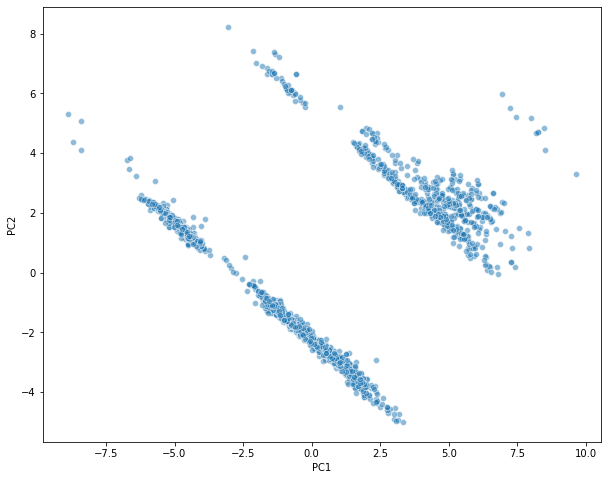

In [131]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
  data=data_pca,
  x='PC1',
  y='PC2',
  alpha=0.5,
  ax=ax
  )

## Apply KMeans

In [132]:
results = []

# train models with n number of clusters
for n in range(2,10): # evaluate 2 to 12 clusters
        # fit the algorithm with n clusters
    model = KMeans(n_clusters=n)
    clusters = model.fit(data_pca).labels_
        # capture the inertia & silhouette scores for this value of n
    results += [(n, metrics.silhouette_score(data_pca, clusters))]

results_pd = pd.DataFrame(results, columns=['n', 'silhouette'])

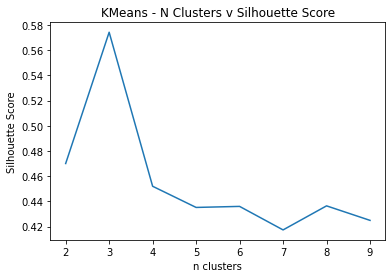

In [133]:
plt.figure(figsize=(6,4))
plt.plot(results_pd['n'], results_pd['silhouette'])
plt.xlabel('n clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans - N Clusters v Silhouette Score')
plt.show()

In [134]:
X = data_pca
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

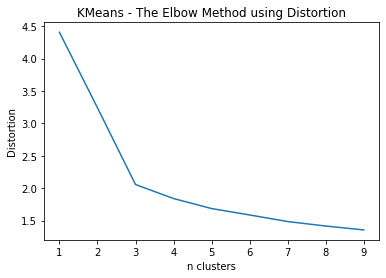

In [135]:
plt.figure(figsize=(6,4))
plt.plot(K, distortions)
plt.xlabel('n clusters')
plt.ylabel('Distortion')
plt.title('KMeans - The Elbow Method using Distortion')
plt.show()

The above charts indicate that 3 clusters is the best option for this problem, so let's train the model with 3 clusters. 

In [136]:
n = 3
 
# configure model
best_model_km = KMeans( n_clusters=n)

# train and predict clusters
best_clusters_km = best_model_km.fit(X).labels_

# score results
best_score_km = metrics.silhouette_score(X, best_clusters_km)

# print best score obtained
print('Silhouette Score: {0:.6f}'.format(best_score_km))

# combine households with cluster assignments
best_labeled_X_df_km = (
  pd.concat( 
    [X, pd.DataFrame(best_clusters_km,columns=['cluster'])],
    axis=1
    )
  )

Silhouette Score: 0.574303


In [137]:
# modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def plot_silhouette_chart(features, labels):
  
      n = len(np.unique(labels))

      # configure plot area
      fig, ax = plt.subplots(1, 1)
      fig.set_size_inches(8, 5)

      # configure plots for silhouette scores between -1 and 1
      ax.set_xlim([-0.1, 1])
      ax.set_ylim([0, len(features) + (n + 1) * 10])

      # avg silhouette score
      score = metrics.silhouette_score(features, labels)

      # compute the silhouette scores for each sample
      sample_silhouette_values = metrics.silhouette_samples(features, labels)

      y_lower = 10

      for i in range(n):

          # get and sort members by cluster and score
          ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
          ith_cluster_silhouette_values.sort()

          # size y based on sample count
          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          # pretty up the charts
          color = cm.nipy_spectral(float(i) / n)

          ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # label the silhouette plots with their cluster numbers at the middle
          ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples


      ax.set_title("Average silhouette of {0:.3f} with {1} clusters".format(score, n))
      ax.set_xlabel("The silhouette coefficient values")
      ax.set_ylabel("Cluster label")

      # vertical line for average silhouette score of all the values
      ax.axvline(x=score, color="red", linestyle="--")

      ax.set_yticks([])  # clear the yaxis labels / ticks
      ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      return fig, ax

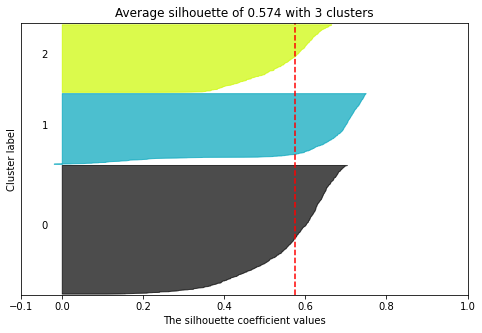

In [138]:
_ = plot_silhouette_chart(X, best_clusters_km)

## Apply Hierarchical Clustering

In [139]:
# # Add back in the categorical data as hierarchical clustering can use it
# cat_features = df[cat_feature_names]

# X = cat_features.merge(data_pca, how='inner', left_index=True, right_index=True)

In [140]:
results = []

# train models with n number of clusters * linkages
for a in ['ward']:  # linkages

    for n in range(2,10): # evaluate 2 to 9 clusters

    # fit the algorithm with n clusters
        model = AgglomerativeClustering(n_clusters=n, linkage=a)
        clusters = model.fit(X).labels_

    # capture the inertia & silhouette scores for this value of n
        results += [ (n, a, metrics.silhouette_score(X, clusters)) ]

 
results_pd = pd.DataFrame(results, columns=['n', 'linkage', 'silhouette'])

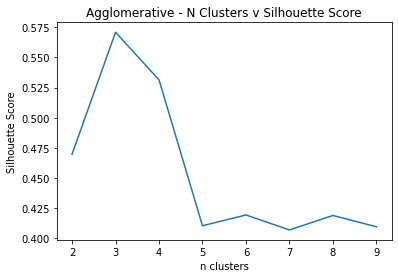

In [141]:
plt.figure(figsize=(6,4))
plt.plot(results_pd['n'], results_pd['silhouette'])
plt.xlabel('n clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative - N Clusters v Silhouette Score')
plt.show()

In [142]:
n = 3
 
# configure model
best_model_hc = AgglomerativeClustering( n_clusters=n)

# train and predict clusters
best_clusters_hc = best_model_hc.fit(X).labels_

# score results
best_score_hc = metrics.silhouette_score(X, best_clusters_hc)

# print best score obtained
print('Silhouette Score: {0:.6f}'.format(best_score_hc))

# combine households with cluster assignments
best_labeled_X_df_hc = (
  pd.concat( 
    [X, pd.DataFrame(best_clusters_hc,columns=['cluster'])],
    axis=1
    )
  )

Silhouette Score: 0.570898


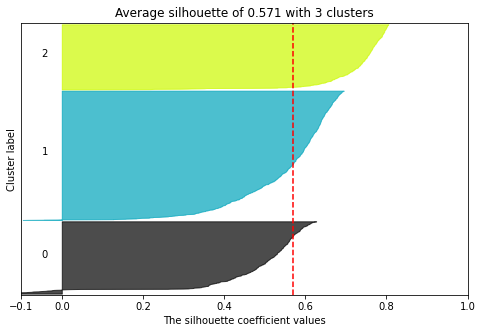

In [143]:
_ = plot_silhouette_chart(X, best_clusters_hc)

In [144]:
## Commented out for speed of running - image saved into report
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(12, 7))
# plt.title("Customer Segmentation Dendrogram")
# dend = shc.dendrogram(shc.linkage(X, method='ward'))

## KPrototypes with PCA for Continuous Features

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2238 non-null   int32  
 1   Marital_Status       2238 non-null   int32  
 2   Income               2238 non-null   float64
 3   Recency              2238 non-null   int64  
 4   NumDealsPurchases    2238 non-null   int64  
 5   NumWebPurchases      2238 non-null   int64  
 6   NumCatalogPurchases  2238 non-null   int64  
 7   NumStorePurchases    2238 non-null   int64  
 8   NumWebVisitsMonth    2238 non-null   int64  
 9   Complain             2238 non-null   int64  
 10  age                  2238 non-null   int64  
 11  has_child            2238 non-null   int32  
 12  total_spend          2238 non-null   int64  
 13  total_purchases      2238 non-null   int64  
 14  promos_accepted      2238 non-null   int64  
 15  tenure               2238 non-null   i

In [146]:
data_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     2238 non-null   float64
 1   PC2     2238 non-null   float64
 2   PC3     2238 non-null   float64
 3   PC4     2238 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [147]:
# Add back in the categorical data as kprototypes can use it
cat_features = df[cat_feature_names]

X = cat_features.merge(data_pca, how='inner', left_index=True, right_index=True)

In [148]:
# Define categorical column positions
cat_col_position = []
for i in range(len(cat_feature_names)):
    cat_col_position.append(i)
cat_col_position

[0, 1, 2, 3, 4]

In [149]:
# Convert dataframe to matrix
dfMatrix = X.to_numpy()
#dfMatrix

array([[ 1.        ,  0.        ,  0.        , ...,  1.31335695,
        -2.11815267,  0.73059794],
       [ 1.        ,  0.        ,  1.        , ..., -0.76887695,
         0.81546565,  2.56425705],
       [ 0.        ,  0.        ,  0.        , ..., -2.6220126 ,
         0.6909714 , -0.90868751],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.42482261,
         0.91295989, -2.55657242],
       [ 0.        ,  0.        ,  1.        , ..., -3.00884518,
         0.57711783, -0.37549697],
       [ 1.        ,  0.        ,  0.        , ...,  3.17584146,
        -1.25776502,  0.57937509]])

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7


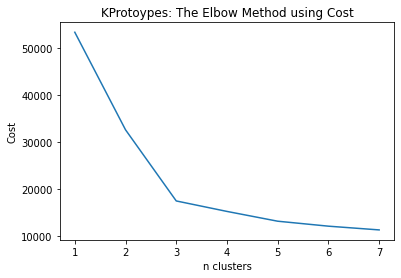

In [150]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1,8):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical=cat_col_position)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break  # Converting the results into a dataframe and plotting them
        
df_cost = pd.DataFrame({'Cluster':range(1,8), 'Cost':cost})# Data viz

plt.plot(df_cost['Cluster'], df_cost['Cost'])
plt.xlabel('n clusters')
plt.ylabel('Cost')
plt.title('KProtoypes: The Elbow Method using Cost')
plt.show()

In [151]:
n = 3
# configure model
best_model_kp = KPrototypes(n_jobs = -1, n_clusters =n, init = 'Huang', random_state = 0)

# train and predict clusters
best_clusters_kp = best_model_kp.fit_predict(dfMatrix, categorical = cat_col_position)

# score results
best_score_kp = metrics.silhouette_score(dfMatrix, best_clusters_kp)

# print best score obtained
print('Silhouette Score: {0:.6f}'.format(best_score_kp))

# combine households with cluster assignments
X = pd.DataFrame(dfMatrix)

best_labeled_X_df = (
  pd.concat( 
    [X, pd.DataFrame(best_clusters_kp,columns=['cluster'])],
    axis=1
    )
  )

Silhouette Score: 0.501484


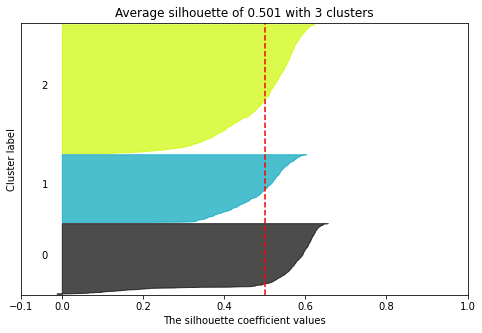

In [152]:
_ = plot_silhouette_chart(X, best_clusters_kp)

## Profiling

Using the best result which was the KMeans algorithm for 3 clusters using data pre-processed with PCA, I will profile the resulting clusters.

In [163]:
#best_labeled_X_df_km

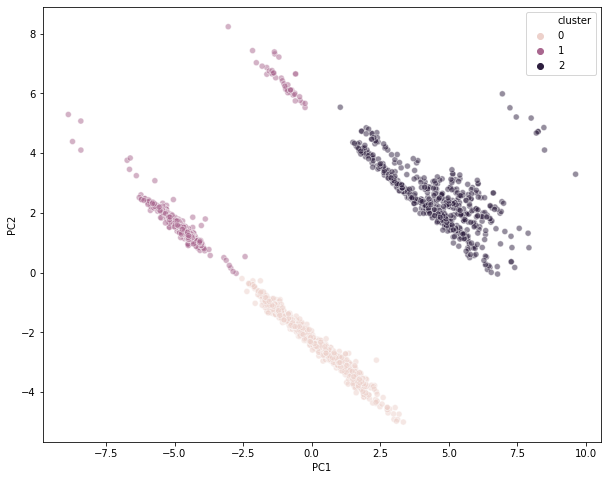

In [154]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
    data=best_labeled_X_df_km,
    x='PC1',
    y='PC2',
    hue='cluster',
    alpha=0.5,
    ax=ax
      )

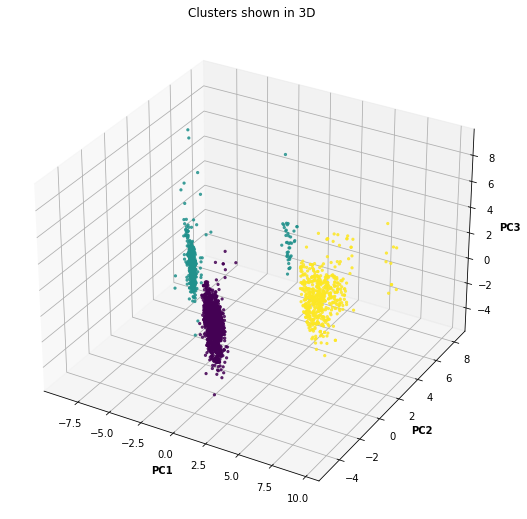

In [162]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 

 
# Creating plot
sctt = ax.scatter3D(best_labeled_X_df_km["PC1"], best_labeled_X_df_km["PC2"], best_labeled_X_df_km["PC3"],
                    alpha = 0.8,
                    c = (best_labeled_X_df_km["cluster"]),
                    marker ='.')
 
plt.title("Clusters shown in 3D")
ax.set_xlabel('PC1', fontweight ='bold')
ax.set_ylabel('PC2', fontweight ='bold')
ax.set_zlabel('PC3', fontweight ='bold')
 
# show plot
plt.show()

In [160]:
df_km = (
  pd.concat( 
    [df, pd.DataFrame(best_clusters_km,columns=['cluster'])],
    axis=1
    )
  )

#df_km

In [157]:
cluster_column = 'cluster'
cluster_count = len(np.unique(df_km[cluster_column]))
cluster_colors = [cm.nipy_spectral(float(i)/cluster_count) for i in range(cluster_count)]

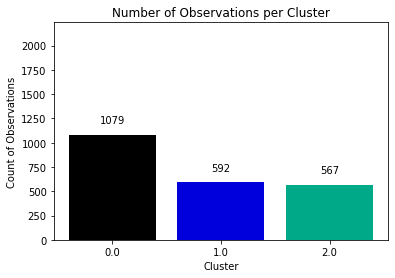

In [161]:
# count members per cluster
cluster_member_counts = df_km.groupby([cluster_column]).agg({cluster_column:['count']})
cluster_member_counts.columns = cluster_member_counts.columns.droplevel(0)

# plot counts
plt.bar(
  cluster_member_counts.index,
  cluster_member_counts['count'],
  color = cluster_colors,
  tick_label=cluster_member_counts.index
  )

# stretch y-axis
plt.ylim(0,df_km.shape[0])
plt.title("Number of Observations per Cluster")
plt.xlabel('Cluster')
plt.ylabel('Count of Observations')

# labels
for index, value in zip(cluster_member_counts.index, cluster_member_counts['count']):
    plt.text(index, value, str(value)+'\n', horizontalalignment='center', verticalalignment='baseline')

In [159]:
df_cluster_summary = df_km.groupby('cluster').mean().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})
df_cluster_summary

cluster,index,0.0,1.0,2.0
0,Education,0.974954,0.959391,0.966490
1,Marital_Status,0.340445,0.350254,0.389771
2,Income,54056.300557,40835.179357,58530.611993
3,Recency,50.770872,48.416244,46.855379
4,NumDealsPurchases,2.541744,2.040609,2.206349
5,NumWebPurchases,4.462894,2.940778,4.559083
6,NumCatalogPurchases,2.954545,1.255499,3.578483
7,NumStorePurchases,6.335807,4.211506,6.403880
8,NumWebVisitsMonth,5.075139,6.128596,4.925926
9,Complain,0.006494,0.015228,0.008818
